In [2]:
import pandas as pd
import datetime

# ---- Clean column names and values ----
df = pd.read_csv("../CRIS_data/train_demand/demand_22222.csv")
df.columns = df.columns.str.strip().str.replace("'", "")
df['booking_date'] = pd.to_datetime(df['booking_date'])
df['journey_date'] = pd.to_datetime(df['journey_date'])

for col in ['trnno', 'brdpt_code', 'resupto_code', 'cls']:
    df[col] = df[col].astype(str).str.strip().str.replace("'", "")
df['PSGN'] = df['PSGN'].astype(int)

# ---- Holiday dictionary ----
holidays = {
    # 2023
    "26-01-2023": "Republic Day",
    "15-08-2023": "Independence Day",
    "02-10-2023": "Gandhi Jayanti",
    "25-12-2023": "Christmas",
    "12-11-2023": "Diwali",
    "07-03-2023": "Holi",
    "05-09-2023": "Eid",

    # 2024
    "26-01-2024": "Republic Day",
    "15-08-2024": "Independence Day",
    "02-10-2024": "Gandhi Jayanti",
    "25-12-2024": "Christmas",
    "31-10-2024": "Diwali",
    "15-08-2024": "Raksha Bandhan",
    "26-08-2024": "Janmashtami",
    "25-03-2024": "Holi",

    # 2025
    "26-01-2025": "Republic Day",
    "15-08-2025": "Independence Day",
    "02-10-2025": "Gandhi Jayanti",
    "25-12-2025": "Christmas",
    "20-10-2025": "Diwali",
    "31-03-2025": "Holi",
    "05-09-2025": "Eid",
}

# ---- Helper function for peak day ----
def check_peak(date_obj):
    date_str = date_obj.strftime("%d-%m-%Y")
    weekday = date_obj.weekday()
    is_peak = False

    # If holiday
    if date_str in holidays:
        is_peak = True

    # Weekend (Sat=5, Sun=6)
    if weekday >= 5:
        is_peak = True

    # Thursday before Friday holiday
    if weekday == 3:
        next_day = date_obj + datetime.timedelta(days=1)
        if next_day.strftime("%d-%m-%Y") in holidays and next_day.weekday() == 4:
            is_peak = True

    # Friday before Monday holiday
    if weekday == 4:
        next_monday = date_obj + datetime.timedelta(days=3)
        if next_monday.strftime("%d-%m-%Y") in holidays and next_monday.weekday() == 0:
            is_peak = True

    return int(is_peak)

# ---- Add new columns ----
df['weekday'] = df['journey_date'].dt.weekday

def season(month):
    if month in [5, 6]:   # May, June
        return 1  # Summer
    elif month in [11, 12, 1, 2]:  # Nov, Dec, Jan, Feb
        return 2  # Winter
    else:
        return 0  # Other

df['season'] = df['journey_date'].dt.month.apply(season)
df['is_peak_day'] = df['journey_date'].apply(check_peak)

df.head()


,booking_date,journey_date,trnno,brdpt_code,resupto_code,cls,PSGN,weekday,season,is_peak_day
0,2023-04-06,2023-08-01,22222,AGC,KYN,3A,6,1,0,0
1,2023-04-14,2023-08-01,22222,NZM,NK,3A,1,1,0,0
2,2023-05-02,2023-08-01,22222,NZM,CSMT,1A,4,1,0,0
3,2023-05-03,2023-08-01,22222,NZM,NK,2A,2,1,0,0
4,2023-05-14,2023-08-01,22222,NZM,NK,3A,1,1,0,0


C:\Users\Asus\AppData\Local\Temp\ipykernel_17664\2989490489.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['season', 'cls', 'days_bin', 'journey_date'])['PSGN']
C:\Users\Asus\AppData\Local\Temp\ipykernel_17664\2989490489.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_journey.groupby(['season', 'cls', 'days_bin'])['tickets_per_journey']


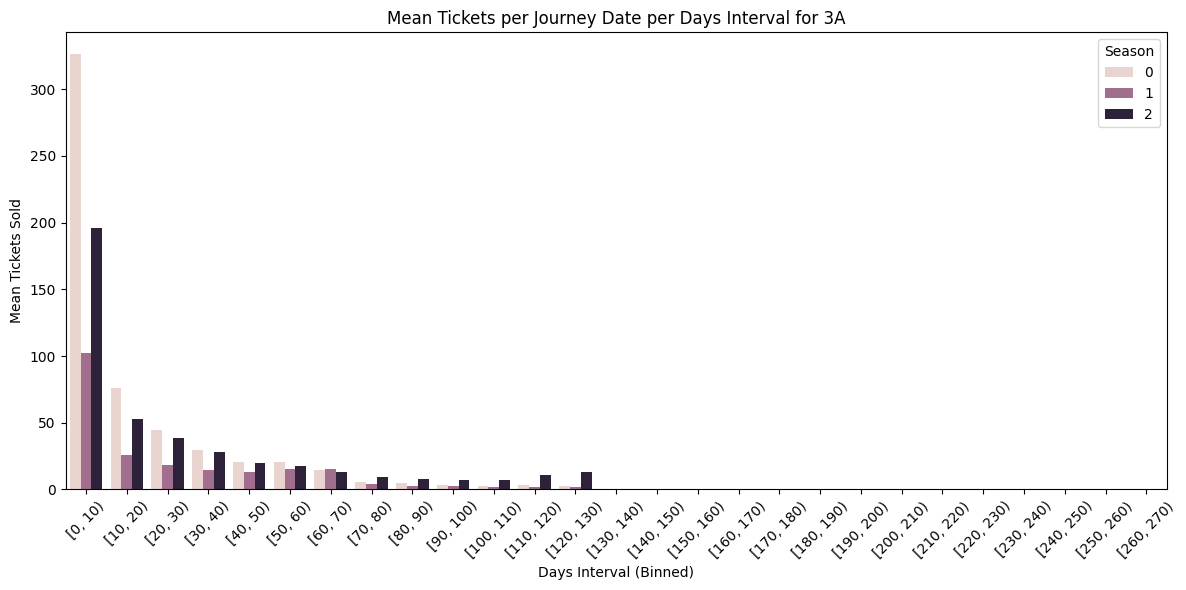

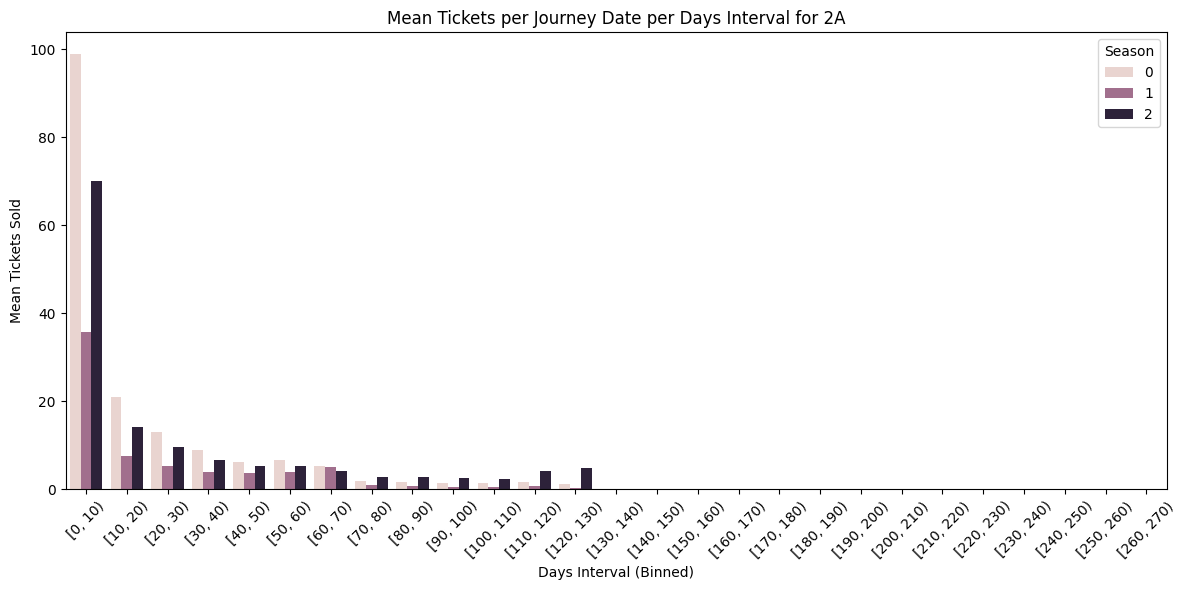

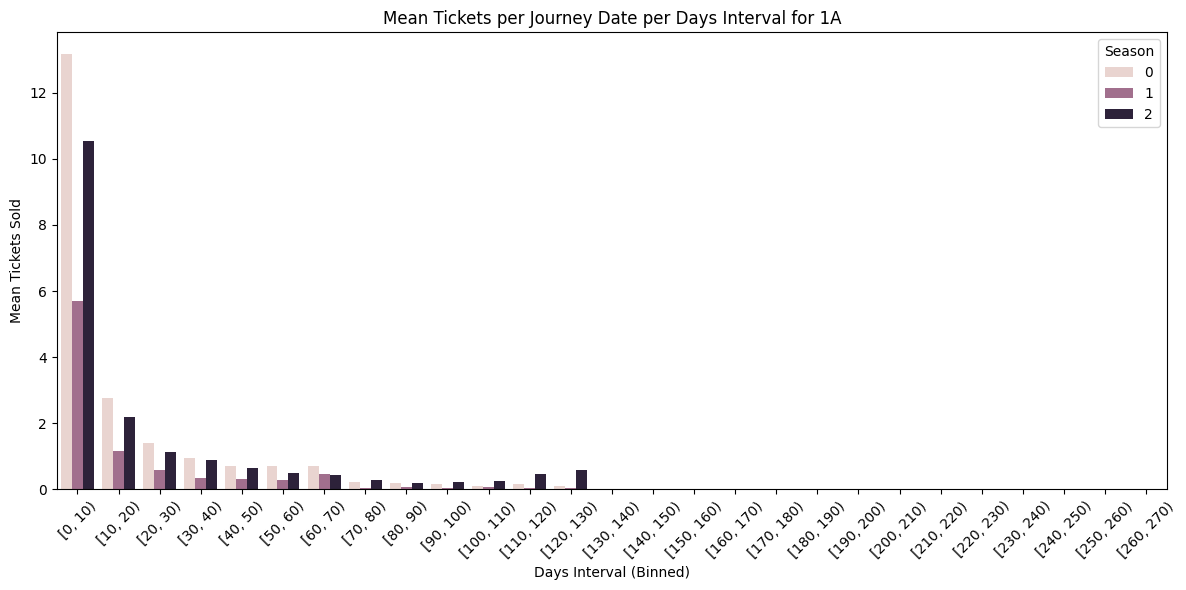

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded
df['cls'] = df['cls'].astype(str).str.strip()
df['booking_date'] = pd.to_datetime(df['booking_date'])
df['journey_date'] = pd.to_datetime(df['journey_date'])

# Days interval
df['days_interval'] = (df['journey_date'] - df['booking_date']).dt.days

# Create bins of 10 days each
bin_edges = list(range(0, df['days_interval'].max() + 10, 10))
df['days_bin'] = pd.cut(df['days_interval'], bins=bin_edges, right=False)

# Step 1: group by season, class, days_bin, journey_date -> sum tickets for that journey_date
df_journey = (
    df.groupby(['season', 'cls', 'days_bin', 'journey_date'])['PSGN']
      .sum()
      .reset_index(name="tickets_per_journey")
)

# Step 2: now average over journey_date (mean = total tickets / number of unique journeys)
df_mean = (
    df_journey.groupby(['season', 'cls', 'days_bin'])['tickets_per_journey']
      .mean()
      .reset_index(name="mean_tickets")
)

# Classes of interest
classes = ['3A', '2A', '1A']

# Plot bar graphs
for c in classes:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_mean[df_mean['cls'] == c],
        x='days_bin',
        y='mean_tickets',
        hue='season'
    )
    plt.title(f"Mean Tickets per Journey Date per Days Interval for {c}")
    plt.xlabel("Days Interval (Binned)")
    plt.ylabel("Mean Tickets Sold")
    plt.legend(title="Season")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


  Class  Skewness
0    1A  2.478420
1    2A  1.782061
2    3A  1.533706


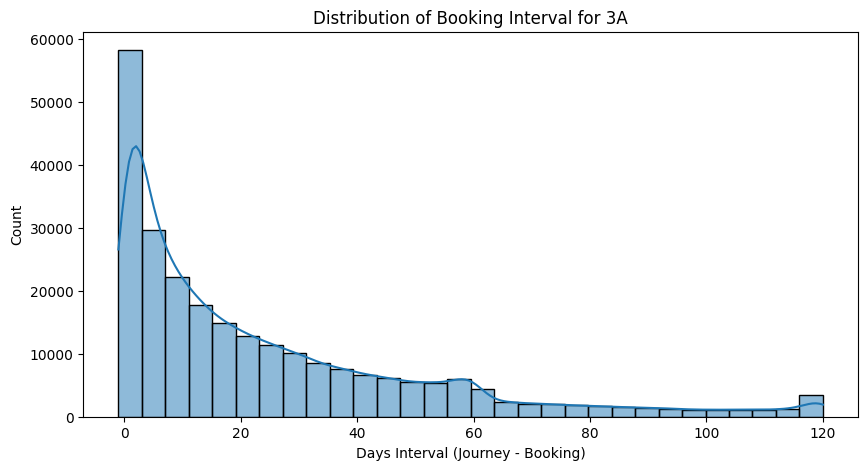

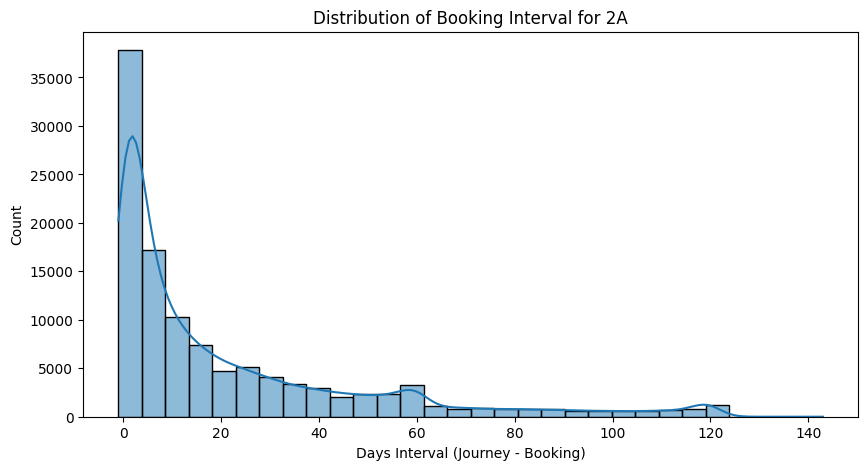

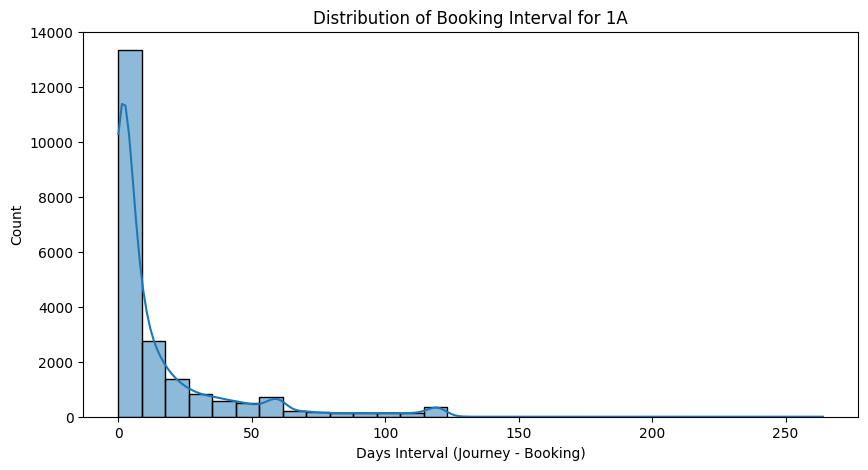

In [10]:
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt

# Compute skewness of days_interval per class
skewness_results = df.groupby('cls')['days_interval'].apply(lambda x: skew(x.dropna())).reset_index()
skewness_results.columns = ['Class', 'Skewness']
print(skewness_results)

# Plot distribution curves
classes = ['3A', '2A', '1A']
for c in classes:
    plt.figure(figsize=(10,5))
    sns.histplot(df[df['cls'] == c]['days_interval'], kde=True, bins=30)
    plt.title(f"Distribution of Booking Interval for {c}")
    plt.xlabel("Days Interval (Journey - Booking)")
    plt.ylabel("Count")
    plt.show()


  cls  season  Skewness
0  1A       0  2.491090
1  1A       1  2.422509
2  1A       2  2.235887
3  2A       0  1.999962
4  2A       1  1.584565
5  2A       2  1.504571
6  3A       0  1.716645
7  3A       1  1.339333
8  3A       2  1.300259


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


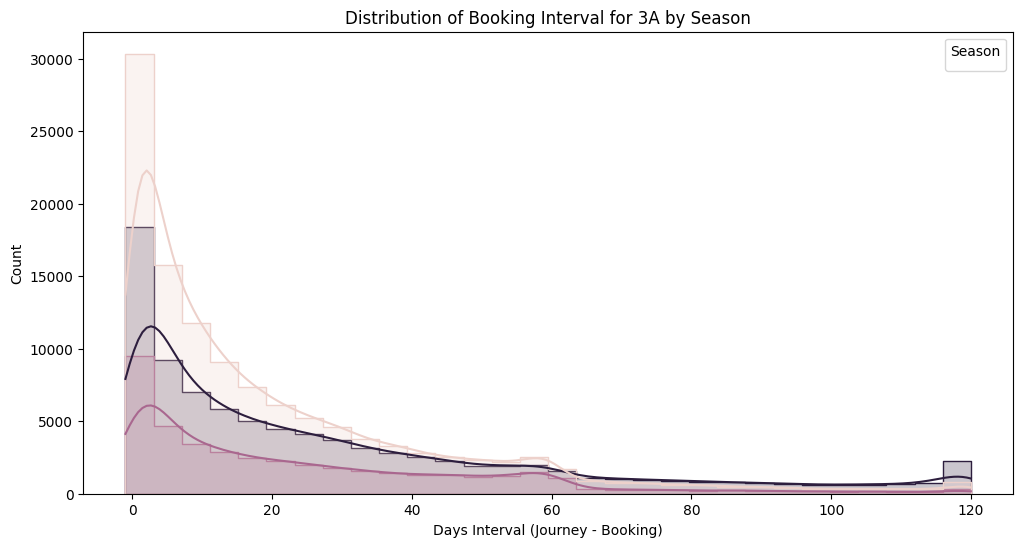

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


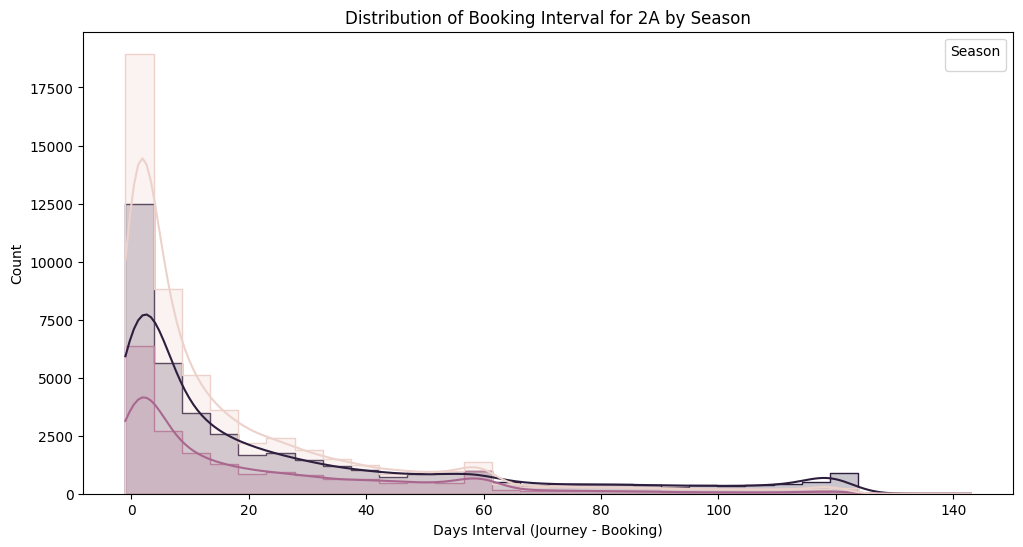

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


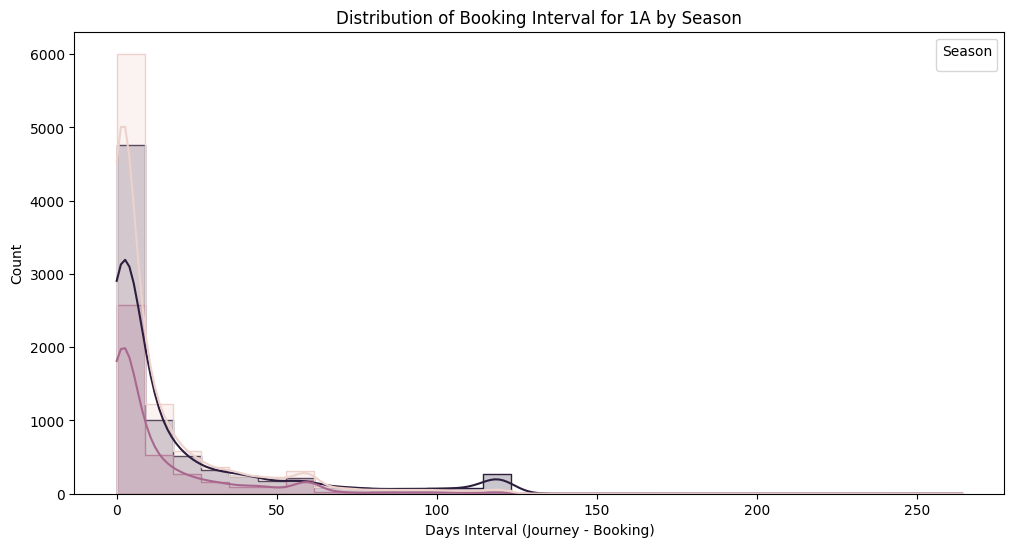

In [11]:
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt

# Compute skewness of days_interval per (cls, season)
skewness_results = (
    df.groupby(['cls', 'season'])['days_interval']
      .apply(lambda x: skew(x.dropna()))
      .reset_index(name="Skewness")
)

print(skewness_results)

# Plot distributions
classes = ['3A', '2A', '1A']
for c in classes:
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=df[df['cls'] == c],
        x='days_interval',
        hue='season',
        kde=True,
        bins=30,
        element="step",
        common_norm=False
    )
    plt.title(f"Distribution of Booking Interval for {c} by Season")
    plt.xlabel("Days Interval (Journey - Booking)")
    plt.ylabel("Count")
    plt.legend(title="Season")
    plt.show()


In [2]:
print(df[df['is_peak_day'] == 1].head())


     booking_date journey_date  trnno brdpt_code resupto_code  cls  PSGN  \
1557   2023-04-11   2023-08-05  22222       NZM          NK    2A      1   
1558   2023-04-27   2023-08-05  22222       AGC          CSMT  2A      2   
1559   2023-04-27   2023-08-05  22222       AGC          NK    2A      1   
1560   2023-04-27   2023-08-05  22222       NZM          KYN   3A      1   
1561   2023-04-28   2023-08-05  22222       NZM          NK    2A      5   

      weekday  season  is_peak_day  
1557        5       0            1  
1558        5       0            1  
1559        5       0            1  
1560        5       0            1  
1561        5       0            1  


In [3]:
print(df[df['booking_date'] == '2023-04-11'].head())

     booking_date journey_date  trnno brdpt_code resupto_code  cls  PSGN  \
1557   2023-04-11   2023-08-05  22222       NZM          NK    2A      1   
2518   2023-04-11   2023-08-07  22222       AGC          NK    3A      1   
2908   2023-04-11   2023-08-08  22222       VGLJ         NK    2A      4   

      weekday  season  is_peak_day  
1557        5       0            1  
2518        0       0            0  
2908        1       0            0  


In [4]:
df['days_to_departure'] = (df['journey_date'] - df['booking_date']).dt.days
df['cls'] = df['cls'].astype(str).str.strip()
print(df['cls'].unique())

['3A' '1A' '2A']


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# --- Preprocess ---
df['booking_date'] = pd.to_datetime(df['booking_date'])
df['journey_date'] = pd.to_datetime(df['journey_date'])

# Add numeric date features
df['journey_month'] = df['journey_date'].dt.month
df['journey_day']   = df['journey_date'].dt.day
df['journey_year']  = df['journey_date'].dt.year

# --- Focus on Class 3A ---
df_class = df[df['cls'] == '3A'].copy()

# Features & target
features = [
    'journey_month','journey_day','journey_year',
    'days_to_departure','weekday','season','is_peak_day'
]
X = df_class[features]
y = df_class['PSGN']

# Split: train on 2023, test on 2024
X_train = X[df_class['journey_year'] == 2023]
y_train = y[df_class['journey_year'] == 2023]
X_test  = X[df_class['journey_year'] == 2024]
y_test  = y[df_class['journey_year'] == 2024]

if len(X_train) == 0 or len(X_test) == 0:
    print("Not enough data for 2023/2024 split")
else:
    # Train model
    model = RandomForestRegressor(
        n_estimators=200, 
        max_depth=10, 
        random_state=42
    )
    model.fit(X_train, y_train)

    # Evaluate
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Class 3A: MAE={mae:.2f}, R²={r2:.2f}")


Class 3A: MAE=2.48, R²=0.08


In [6]:
df_grouped = df.groupby(['booking_date', 'journey_date', 'cls'], as_index=False)['PSGN'].sum()
df_grouped['days_to_departure'] = (df['journey_date'] - df['booking_date']).dt.days

df_grouped.head()

,booking_date,journey_date,cls,PSGN,days_to_departure
0,2023-04-05,2023-08-03,2A,2,117
1,2023-04-06,2023-08-01,3A,6,109
2,2023-04-06,2023-08-03,2A,1,91
3,2023-04-06,2023-08-04,2A,3,90
4,2023-04-06,2023-08-04,3A,2,79


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Pick a journey date to visualize (must exist in your data)
journey_date = pd.to_datetime("2023-11-12")

# Predict bookings for 0–60 days before departure
predictions = []
for d in range(0, 61):
    X_new = pd.DataFrame([{
        "journey_month": journey_date.month,
        "journey_day": journey_date.day,
        "journey_year": journey_date.year,
        "days_to_departure": d,
        "weekday": journey_date.weekday(),
        "season": 2,       # example: winter
        "is_peak_day": 1   # example: holiday/weekend
    }])
    pred = models["3A"].predict(X_new)[0]
    predictions.append(pred)

# Predictions DataFrame
df_pred = pd.DataFrame({
    "days_to_departure": list(range(0, 61)),
    "predicted_PSGN": predictions
})

# Actual 3A bookings for that journey_date
df_actual = df[
    (df["cls"] == "3A") & (df["journey_date"] == journey_date)
][["days_to_departure", "PSGN"]]

# Plot predicted vs. actual
plt.figure(figsize=(10, 6))
plt.plot(df_pred["days_to_departure"], df_pred["predicted_PSGN"],
         label="Predicted 3A bookings", color="blue")
plt.scatter(df_actual["days_to_departure"], df_actual["PSGN"],
            label="Actual 3A bookings", color="red")
plt.gca().invert_xaxis()  # so departure approaches from left to right
plt.xlabel("Days to Departure")
plt.ylabel("Passengers (PSGN)")
plt.title(f"3A Bookings Prediction vs Actual for {journey_date.date()}")
plt.legend()
plt.show()


NameError: name 'models' is not defined